In [1]:
# simplest example available

In [2]:
import rmgpy.chemkin
import os

import cantera as ct
import numpy as np
import logging

import rmgpy.solver  # import SimpleReactor, TerminationTime, SurfaceReactor
import rmgpy.quantity  #import Quantity
import rmgpy.rmg.listener # import SimulationProfileWriter, SimulationProfilePlotter
import rmgpy.rmg.settings  #import ModelSettings, SimulatorSettings

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# logging.basicConfig(level=logging.DEBUG)
import rmgpy.constants as constants
from rmgpy.kinetics import SurfaceArrhenius, StickingCoefficient
from rmgpy.molecule import Molecule
from rmgpy.reaction import Reaction
# from rmgpy.solver.surface import SurfaceReactor
from rmgpy.species import Species
from rmgpy.thermo import ThermoData, NASA, NASAPolynomial


In [3]:
# CH3 + X <=>  CH3X


ch3 = Species(
            molecule=[Molecule().from_smiles("[CH3]")],
            thermo=NASA(
                polynomials=[
                    NASAPolynomial(
                        coeffs=[
                            3.91547,
                            0.00184155,
                            3.48741e-06,
                            -3.32746e-09,
                            8.49953e-13,
                            16285.6,
                            0.351743,
                        ],
                        Tmin=(100, "K"),
                        Tmax=(1337.63, "K"),
                    ),
                    NASAPolynomial(
                        coeffs=[
                            3.54146,
                            0.00476786,
                            -1.82148e-06,
                            3.28876e-10,
                            -2.22545e-14,
                            16224,
                            1.66032,
                        ],
                        Tmin=(1337.63, "K"),
                        Tmax=(5000, "K"),
                    ),
                ],
                Tmin=(100, "K"),
                Tmax=(5000, "K"),
                E0=(135.382, "kJ/mol"),
                comment="""Thermo library: primaryThermoLibrary + radical(CH3)""",
            ),
            molecular_weight=(15.0345, "amu"),
        )

x = Species(
    molecule=[Molecule().from_adjacency_list("1 X u0 p0")],
    thermo=NASA(
        polynomials=[
            NASAPolynomial(coeffs=[0, 0, 0, 0, 0, 0, 0], Tmin=(298, "K"), Tmax=(1000, "K")),
            NASAPolynomial(coeffs=[0, 0, 0, 0, 0, 0, 0], Tmin=(1000, "K"), Tmax=(2000, "K")),
        ],
        Tmin=(298, "K"),
        Tmax=(2000, "K"),
        E0=(-6.19426, "kJ/mol"),
        comment="""Thermo library: surfaceThermo""",
    ),
)

ch3x = Species(
    molecule=[
        Molecule().from_adjacency_list(
            """1 C u0 p0 c0 {2,S} {3,S} {4,S} {5,S}
2 H u0 p0 c0 {1,S}
3 H u0 p0 c0 {1,S}
4 H u0 p0 c0 {1,S}
5 X u0 p0 c0 {1,S}"""
        )
    ],
    thermo=NASA(
        polynomials=[
            NASAPolynomial(
                coeffs=[
                    -0.552219,
                    0.026442,
                    -3.55617e-05,
                    2.60044e-08,
                    -7.52707e-12,
                    -4433.47,
                    0.692144,
                ],
                Tmin=(298, "K"),
                Tmax=(1000, "K"),
            ),
            NASAPolynomial(
                coeffs=[
                    3.62557,
                    0.00739512,
                    -2.43797e-06,
                    1.86159e-10,
                    3.6485e-14,
                    -5187.22,
                    -18.9668,
                ],
                Tmin=(1000, "K"),
                Tmax=(2000, "K"),
            ),
        ],
        Tmin=(298, "K"),
        Tmax=(2000, "K"),
        E0=(-39.1285, "kJ/mol"),
        comment="""Thermo library: surfaceThermoNi111""",
    ),
)

rxn1 = Reaction(
            reactants=[ch3, x],
            products=[ch3x],
            kinetics=StickingCoefficient(
                A=0.1,
                n=0,
                Ea=(0, "kcal/mol"),
                T0=(1, "K"),
                Tmin=(200, "K"),
                Tmax=(3000, "K"),
                comment="""Exact match found for rate rule (Adsorbate;VacantSite)""",
            )
            # kinetics=SurfaceArrhenius(A=(2.7e10, 'cm^3/(mol*s)'),
            #                           n=0.5,
            #                           Ea=(5.0, 'kJ/mol'),
            #                           T0=(1.0, 'K'))
        )
        

In [4]:
core_species = [ch3, x, ch3x]
edge_species = []
core_reactions = [rxn1]
edge_reactions = []

T = 800.0
P_initial = 1.0e5
rxn_system = rmgpy.solver.SurfaceReactor(
    T,
    P_initial,
    n_sims=1,
    initial_gas_mole_fractions={ch3: 1.0},
    initial_surface_coverages={x: 1.0},
    surface_volume_ratio=(1.0, "m^-1"),
    surface_site_density=(2.72e-9, "mol/cm^2"),
    termination=[],
)
# in chemkin, the sites are mostly occupied in about 1e-8 seconds.

In [5]:
rxn_system.initialize_model(core_species, core_reactions, edge_species, edge_reactions)
tlist = np.logspace(-13, -6, 81, dtype=float)


In [6]:
# Integrate to get the solution at each time point
t = []
y = []
ys_rmg = []
reaction_rates = []
species_rates = []
ys_rmg.append(rxn_system.core_species_concentrations)
t.append(rxn_system.t)
# You must make a copy of y because it is overwritten by DASSL at
# each call to advance()
y.append(rxn_system.y.copy())
reaction_rates.append(rxn_system.core_reaction_rates.copy())
species_rates.append(rxn_system.core_species_rates.copy())
print("time: ", t)
print("moles:", y)
print("reaction rates:", reaction_rates)
print("species rates:", species_rates)
for t1 in tlist:
    rxn_system.advance(t1)
    t.append(rxn_system.t)
    # You must make a copy of y because it is overwritten by DASSL at
    # each call to advance()
    y.append(rxn_system.y.copy())
    reaction_rates.append(rxn_system.core_reaction_rates.copy())
    species_rates.append(rxn_system.core_species_rates.copy())
    ys_rmg.append(rxn_system.core_species_concentrations)
# # Convert the solution vectors to np arrays
# t = np.array(t, float)
# y = np.array(y, float)
# reaction_rates = np.array(reaction_rates, float)
# species_rates = np.array(species_rates, float)
# V = constants.R * rxn_system.T.value_si * np.sum(y) / rxn_system.P_initial.value_si

time:  [0.0]
moles: [array([1.00000000e+00, 1.80922911e-06, 0.00000000e+00])]
reaction rates: [array([398.93602176])]
species rates: [array([-398.93602176, -398.93602176,  398.93602176])]


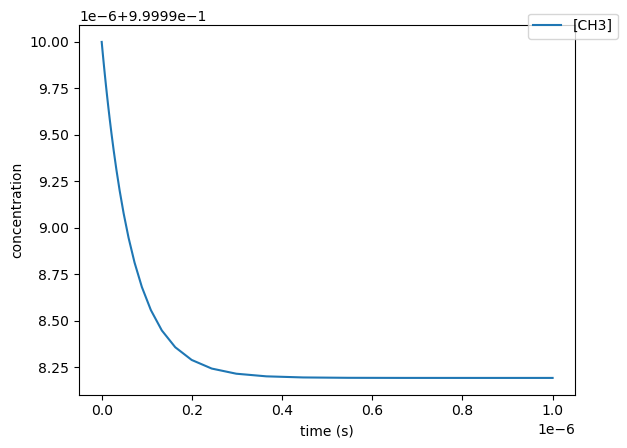

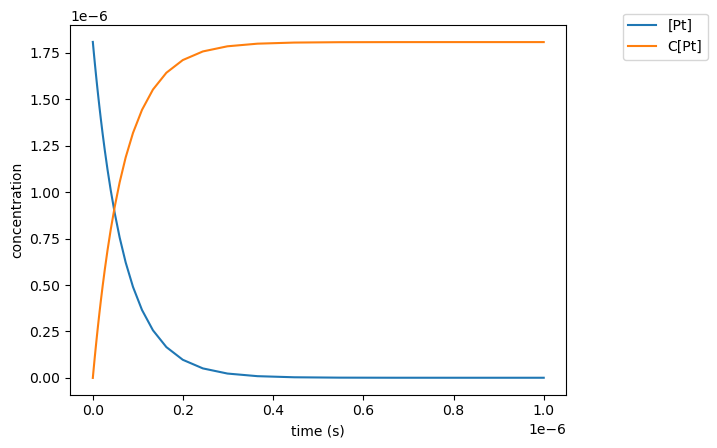

In [7]:

# plot results
for i in range(len(y[0])):
    if core_species[i].contains_surface_site():
        continue
    y_hs = [x[i] for x in y]
    plt.plot(t, y_hs, label=str(core_species[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(len(y[0])):
    if not core_species[i].contains_surface_site():
        continue
    y_hs = [x[i] for x in y]
#     y_hs = [x[i] for x in ys_rmg]
    plt.plot(t, y_hs, label=str(core_species[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')
# plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


In [8]:
# save as Cantera mech

core_species = [ch3, x, ch3x]
edge_species = []
core_reactions = [rxn1]
edge_reactions = []

# rmgpy.chemkin.save_species_dictionary('te')
rmgpy.chemkin.save_chemkin_file('test-gas.inp', [ch3], [])
rmgpy.chemkin.save_chemkin_surface_file('test-surface.inp', [x, ch3x], [rxn1])

In [9]:
surf.species_names

NameError: name 'surf' is not defined

In [42]:
surf.site_density

2.7200000000000002e-08

In [18]:
mech_yaml = 'test-gas.yaml'


surf = ct.Interface(mech_yaml, 'surface1')
gas = surf.adjacent['gas']

T = 800.0
P = 1e5

initial_mole_fractions = '[CH3]: 1.0'  # test data
initial_surface_coverages = '[Pt]:1.0'

gas.TPY = T, P, initial_mole_fractions
surf.TP = T, P
surf.coverages = initial_surface_coverages

catalyst_weight = 4.24e-3
cat_site_per_wt = 5*61.67*1e-6*1e3 # [mol/kg] 1e-6mol/micromole, 1000g/kg
site_density = (
    surf.site_density * 1000
)  # [mol/m^2]cantera uses kmol/m^2, convert to mol/m^2
cat_area = (catalyst_weight * cat_site_per_wt) / site_density  # [m^3]

# gas_reactor = ct.IdealGasReactor(gas, energy='off')
# gas_reactor.volume = 6.0
gas_reactor = ct.IdealGasConstPressureReactor(gas, energy='off')
# opting not to set catalyst area here... we'll see how that goes


surface_reactor = ct.ReactorSurface(surf, gas_reactor)

net = ct.ReactorNet([gas_reactor])

gas_reactor.add_sensitivity_species_enthalpy(0)
gas_reactor.add_sensitivity_species_enthalpy(1)

# #########


# # upstream = ct.Reservoir(gas, name='upstream')

# # # # create a reservoir for the reactor to exhaust into. The composition of
# # # # this reservoir is irrelevant.
# # downstream = ct.Reservoir(gas, name='downstream')

# # V = 30 # velocity m/s (setting very high values allows for effectively fixed gas-phase composition)

# # mass_flow_rate = V * gas.density * 1.0 * 1.0
# # # # The mass flow rate into the reactor will be fixed by using a
# # # # MassFlowController object.
# # m = ct.MassFlowController(upstream, gas_reactor, mdot=mass_flow_rate)

# # v = ct.PressureController(gas_reactor, downstream, master=m, K=1e-5)
# ##############

history = []
gas_history = []

ts_ct = [net.time]
ys_ct = [gas.X]
ys_surf = [surf.coverages]
y_conc = [surf.concentrations]
while net.time < 1e-6:
    net.step()
    ts_ct.append(net.time)
    ys_ct.append(gas.X)
    ys_surf.append(surf.coverages)
    y_conc.append(surf.concentrations)
# plot results
for i in range(len(ys_ct[0])):
    y_hs = [x[i] for x in ys_ct]
    plt.plot(ts_ct, y_hs, label=gas.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i in range(len(ys_surf[0])):
    y_hs = [x[i] for x in ys_surf]
    plt.plot(ts_ct, y_hs, label=surf.species_names[i])
plt.xlabel('time (s)')
plt.ylabel('concentration')
# plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


ValueError: No such species 1.

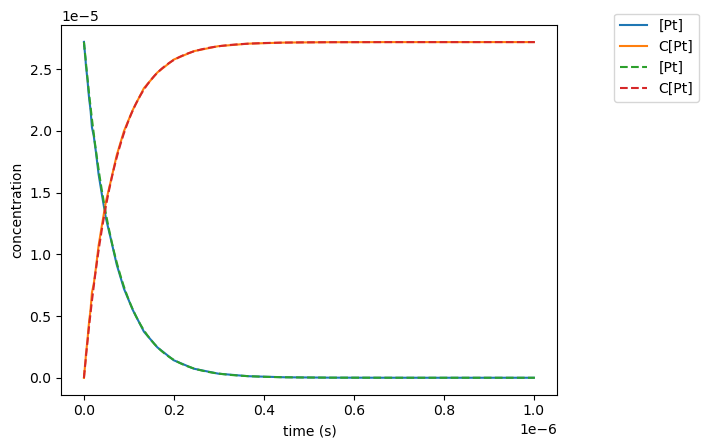

In [11]:
# Plot both together
for i in range(len(y[0])):
    if not core_species[i].contains_surface_site():
        continue
    y_hs = [x[i] for x in ys_rmg]
    plt.plot(t, y_hs, label=str(core_species[i]))
plt.xlabel('time (s)')
plt.ylabel('concentration')

plt.legend(bbox_to_anchor=(1.1, 1.05))


for i in range(len(ys_surf[0])):
    y_hs = [x[i] *1e3 for x in y_conc]
    plt.plot(ts_ct, y_hs, label=surf.species_names[i], linestyle='dashed')
plt.xlabel('time (s)')
plt.ylabel('concentration')

plt.legend(bbox_to_anchor=(1.1, 1.05))


In [ ]:
surface_reactor.add_sensitivity_reaction

In [12]:
surface_reactor.coverages

array([5.08739497e-04, 9.99491261e-01])

In [14]:
gas_reactor.thermo.n_species

1

In [17]:
gas_reactor.add_sensitivity_species_enthalpy(0)

CanteraError: 
*******************************************************************************
CanteraError thrown by ReactorNet::registerSensitivityParameter:
Sensitivity parameters cannot be added after theintegrator has been initialized.
*******************************************************************************


In [15]:
gas_reactor.thermo.species()

[<Species [CH3]>]

In [ ]:
gas_reactor.a

In [ ]:
surface_reactor.